## 확률과 통계 Term Project
#### 제출자: [이승준]
#### 학번: [202431546]
#### 날짜: [2025/06/09]

## 1. 데이터 탐색 및 전처리

(문제 해결 과정)

In [1]:
#필요한 라이브러리 import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from itertools import combinations
from sklearn.model_selection import cross_val_score, KFold
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import skew, kurtosis, probplot



In [27]:
#데이터 불러오기
row = pd.read_csv('tmdb_5000_movies.csv')
data = row[["revenue","budget","runtime","vote_average","vote_count","popularity"]]


In [28]:
#데이터 구조 확인(head(),describe() 사용)
#각 컬럼 값의 단위 차이가 크므로 한눈에 파악하기 쉽도록 단위를 설정
df_scaled = data.copy()

# 단위 변환
df_scaled["revenue"] = df_scaled["revenue"] / 1e6      # 백만 달러
df_scaled["budget"] = df_scaled["budget"] / 1e6        # 백만 달러
df_scaled["vote_count"] = df_scaled["vote_count"] / 1e3  # 천 명 단위

# 출력 포맷 설정 (소수점 2자리)
pd.set_option('display.float_format', '{:.2f}'.format)

# 출력
print(df_scaled.head())
print(df_scaled.describe())

   revenue  budget  runtime  vote_average  vote_count  popularity
0  2787.97  237.00   162.00          7.20       11.80      150.44
1   961.00  300.00   169.00          6.90        4.50      139.08
2   880.67  245.00   148.00          6.30        4.47      107.38
3  1084.94  250.00   165.00          7.60        9.11      112.31
4   284.14  260.00   132.00          6.10        2.12       43.93
       revenue  budget  runtime  vote_average  vote_count  popularity
count  4803.00 4803.00  4801.00       4803.00     4803.00     4803.00
mean     82.26   29.05   106.88          6.09        0.69       21.49
std     162.86   40.72    22.61          1.19        1.23       31.82
min       0.00    0.00     0.00          0.00        0.00        0.00
25%       0.00    0.79    94.00          5.60        0.05        4.67
50%      19.17   15.00   103.00          6.20        0.23       12.92
75%      92.92   40.00   118.00          6.80        0.74       28.31
max    2787.97  380.00   338.00         10.0

 1. budget(제작비)
  - 영화 제작에 사용된 총 비용, 단위 USD.

 2. revenue(수익)
  - 영화가 전 세계적으로 벌어들인 총 수익, 단위 USD.

 3. runtime(상영시간)
  - 영화의 총 상영시간.

 4. vote_average(평균평점)
  - TMDB 사용자들이 부여한 평점의 평균

 5. vote_count(평가 수)
  - TMDB 사용자들이 해당 영화에 대해 평가한 총 횟수.

 6. popularity(인기도 지수)
  - TMDB에서 자체적으로 계산한 영화의 인기도를 나타내는 지수.

        영화
        1. 오늘의 투표 수
        2. 오늘의 조회수
        3. 그날의 "즐겨찾기"로 표시한 사용자 수
        4. 그날의 "관심 목록"에 추가한 사용자 수
        5. 출시일
        6. 총 투표 수
        7. 이전 일 점수

        을 고려한 점수 -> 실시간 트렌드 지표

In [29]:
#결측치처리 - 처리전 데이터의 크기(행)확인
print(data.shape)
print(data.info())

(4803, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   revenue       4803 non-null   int64  
 1   budget        4803 non-null   int64  
 2   runtime       4801 non-null   float64
 3   vote_average  4803 non-null   float64
 4   vote_count    4803 non-null   int64  
 5   popularity    4803 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 225.3 KB
None


In [30]:
#결측치가 있는 행을 제거
data = data.dropna()

In [31]:
#처리 후 데이터 크기 확인
print(data.shape)

(4801, 6)


## 2. 기술통계량 분석

(문제 해결 과정)

In [15]:
#요약 통계량 계산 (각 사용 변수의 평균,중앙값,표준편차 출력)
# 단위 변환용 복사본 생성
df_summary = data.copy()

# 단위 변환: 백만(M) 단위로 변환
df_summary["revenue"] = df_summary["revenue"] / 1e6
df_summary["budget"] = df_summary["budget"] / 1e6
df_summary["vote_count"] = df_summary["vote_count"]  # 그대로
df_summary["popularity"] = df_summary["popularity"]  # 그대로

# 출력 포맷 설정
pd.set_option('display.float_format', '{:.2f}'.format)

# 요약 통계 출력
print(" 평균:\n", df_summary.mean(numeric_only=True))
print("\n 중앙값:\n", df_summary.median(numeric_only=True))
print("\n 표준편차:\n", df_summary.std(numeric_only=True))

# 참고: 단위 안내
print("""
────────────── 단위 안내 ──────────────
• revenue       → 백만 USD
• budget        → 백만 USD
• runtime       → 분
• vote_average  → 점 (0~10)
• vote_count    → 건수
• popularity    → TMDB 지수
────────────────────────────────────
""")

 평균:
 revenue         82.29
budget          29.05
runtime        106.88
vote_average     6.09
vote_count     690.50
popularity      21.50
dtype: float64

 중앙값:
 revenue         19.18
budget          15.00
runtime        103.00
vote_average     6.20
vote_count     236.00
popularity      12.93
dtype: float64

 표준편차:
 revenue         162.88
budget           40.73
runtime          22.61
vote_average      1.19
vote_count     1234.76
popularity       31.82
dtype: float64

────────────── 단위 안내 ──────────────
• revenue       → 백만 USD
• budget        → 백만 USD
• runtime       → 분
• vote_average  → 점 (0~10)
• vote_count    → 건수
• popularity    → TMDB 지수
────────────────────────────────────




1. revenue
- 평균 : 82.29M, 중앙값 : 19.18M, 표준편차 : 162.88M
    
    1) 평균이 중앙값 보다 훨씬 큼 -> 소수의 흥행 대작 영화가 평균을 끌어올리고 오른쪽으로 긴꼬리를 가진 분포를 의미함
    
    2) 표준편차가 평균보다 두 배 이상 큼 -> 수익 분포의 분산이 매우 크고, 대부분의 영화는 평균근처에 있지 않고, 훨씬 낮고 일부는 훨씬 높음

2. budget
- 평균 : 29.05M, 중앙값 : 15M, 표준편차 : 40.73M
    
    1) 평균이 중앙값보다 높음 -> 소수의 초고예산 영화가 전체 평균을 올림
    
    2) 표준편차가 평균보다 큼 -> 예산 편차가 크고 제작비가 영화마다 들쭉날쭉하다.
    
    3) 중앙값이 평균보다 대표

3. runtime
- 평균 : 106.88분, 중앙값 : 103분, 표준편차 : 22.61분
    
    1) 평균이 중앙값과 비슷 -> 정규분포에 가깝고 대부분의 영화
    상영시간은 100분 전후
    
    2) 표준편차 22.61분은 68%의 영화가 85분~130분 사이에 있음을 의미
    
    3) 극단적으로 짧거나 긴영화는 드물다는 의미

4. vote_average
- 평균 : 6.09, 중앙값 : 6.2, 표준편차 : 1.19
    
    1) 평균이 중앙값과 비슷 -> 정규분포에 가깝고 대부분의 영화는 5~7점대
    
    2) 표준편차 1.19점은 68%영화가 5~7.2점 사이에 있음을 의미

5. vote_count
- 평균 : 690.22, 중앙값 : 236, 표준편차 : 1,234.76
    
    1) 평균이 중앙값보다 훨씬 큼 -> 극단적인 우측 왜도, 소수의 인기 영화가 많은 투표를 받아 평균을 끌어올림
    
    2) 표준편차가 평균보다 큼 -> 투표 수 편차가 매우크고,  일부 영화는 거의 안 보거나 무시, 일부는 압도적 관심
    
    3) 대중이 소수의 작품에 집중, 추천 시스템, 배급의 영향이 큼

6. popularity
- 평균 : 21.49, 중앙값 : 12.93, 표준편차: 31.82
    
    1) 평균이 중앙값보다 큼 -> 인기 지수도 상위 일부 영화가 극단적으로 높음
    
    2) 표준편차가 평균보다 큼 -> 인기 지수의 스케일이 정규적이지 않음

In [32]:
#상관관계(revenu(예측변수와 나머지 5개 입력변수 사이의 상관관계 출력, 주석을 사용해 예측변수와 선형관계를 대석))
correlations = data.corr()
print("\n[상관관계 (revenue와 다른 변수들)]\n", correlations["revenue"])


[상관관계 (revenue와 다른 변수들)]
 revenue        1.00
budget         0.73
runtime        0.25
vote_average   0.20
vote_count     0.78
popularity     0.64
Name: revenue, dtype: float64



해석:
- revenue vs budget: 양의 상관관계 → 제작비가 높을수록 수익도 증가하는 경향 있음
- revenue vs runtime: 약한 상관관계 → 상영 시간이 길다고 꼭 수익이 높지는 않음
- revenue vs vote_average: 거의 무관함 → 평점이 높다고 해서 수익이 높지는 않음
- revenue vs vote_count: 강한 양의 상관관계 → 많이 평가된 영화일수록 흥행 성공 가능성 높음
- revenue vs popularity: 중간 정도의 양의 상관관계 → 인기 지수는 수익과 어느 정도 연관 있음


## 3. 이상치 탐색 및 시각화

(문제 해결 과정)

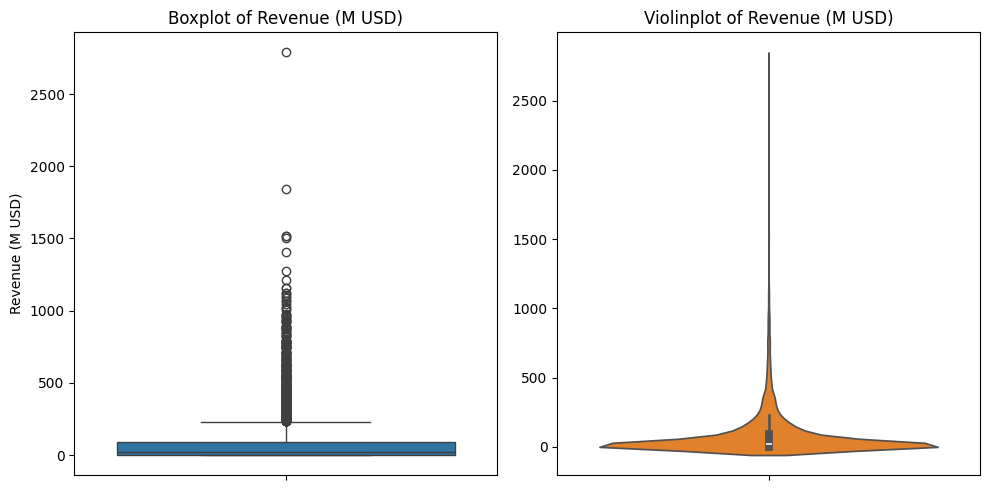

▶ Revenue (M USD) 이상치 수: 472개
   - 하한: -139.38
   - 상한: 232.30
   - 전체 데이터 대비 이상치 비율: 9.83%
   - Q1: 0.00, Q3: 92.92, IQR: 92.92



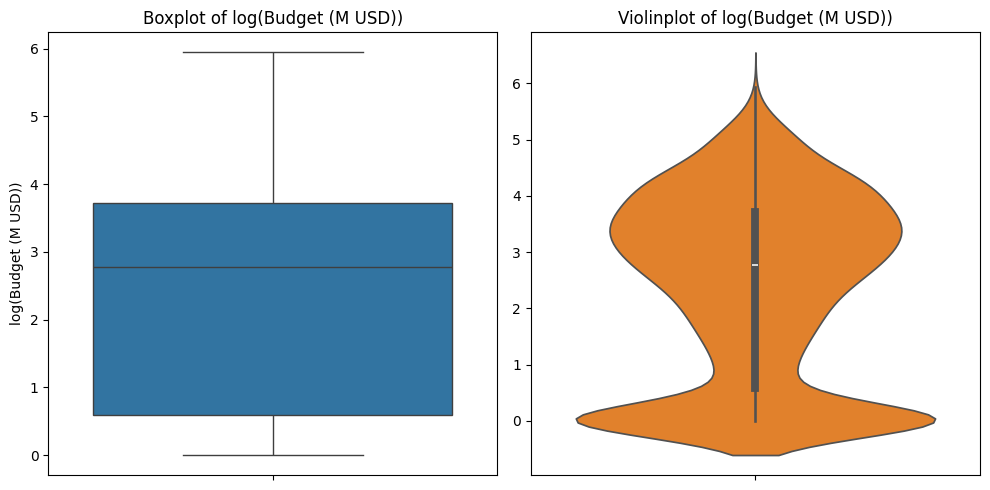

▶ log(Budget (M USD)) 이상치 수: 0개
   - 하한: -4.10
   - 상한: 8.40
   - 전체 데이터 대비 이상치 비율: 0.00%
   - Q1: 0.59, Q3: 3.71, IQR: 3.13



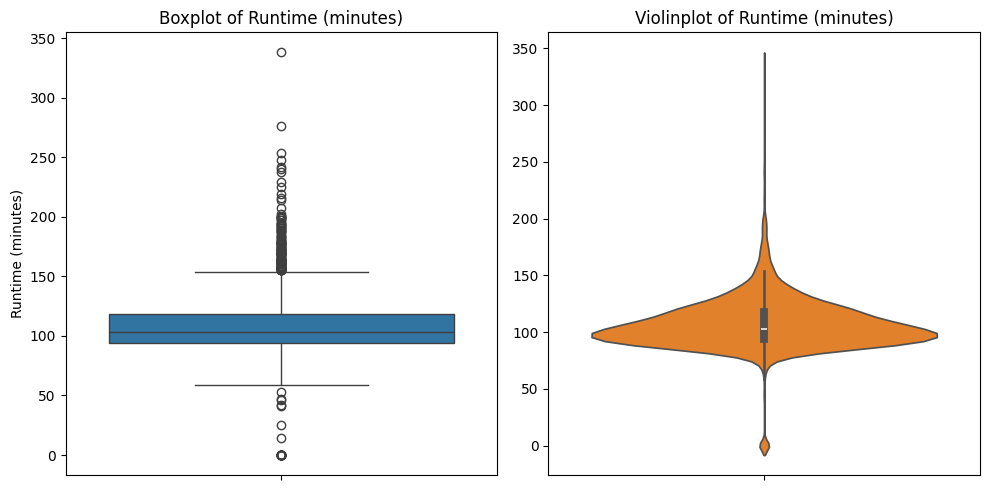

▶ Runtime (minutes) 이상치 수: 182개
   - 하한: 58.00
   - 상한: 154.00
   - 전체 데이터 대비 이상치 비율: 3.79%
   - Q1: 94.00, Q3: 118.00, IQR: 24.00



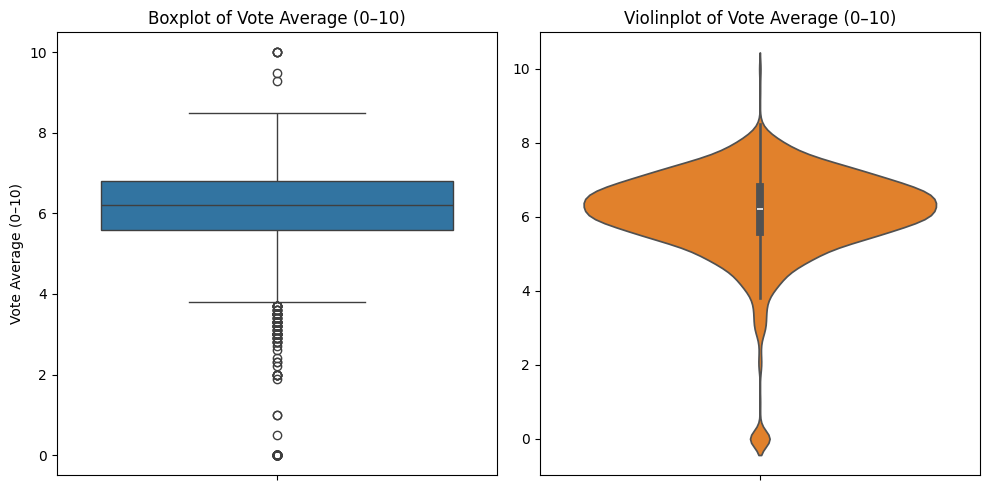

▶ Vote Average (0–10) 이상치 수: 155개
   - 하한: 3.80
   - 상한: 8.60
   - 전체 데이터 대비 이상치 비율: 3.23%
   - Q1: 5.60, Q3: 6.80, IQR: 1.20



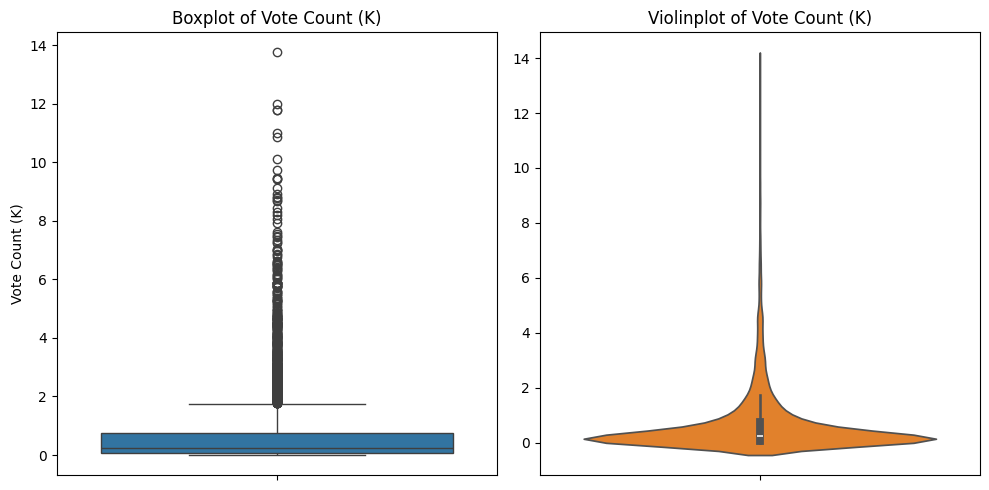

▶ Vote Count (K) 이상치 수: 504개
   - 하한: -0.97
   - 상한: 1.76
   - 전체 데이터 대비 이상치 비율: 10.50%
   - Q1: 0.05, Q3: 0.74, IQR: 0.68



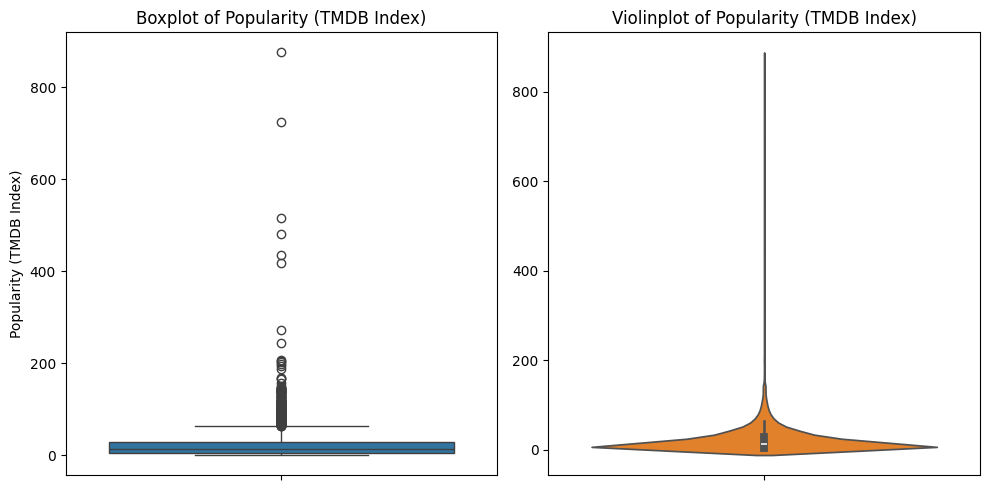

▶ Popularity (TMDB Index) 이상치 수: 274개
   - 하한: -30.83
   - 상한: 63.86
   - 전체 데이터 대비 이상치 비율: 5.71%
   - Q1: 4.68, Q3: 28.35, IQR: 23.67



In [33]:
#3. 이상치 탐색 및 시각화
# 단위 변환
data["revenue_M"] = data["revenue"] / 1e6
data["budget_M"] = data["budget"] / 1e6
data["vote_count_K"] = data["vote_count"] / 1e3

def plot_box_and_count_outliers(col, label=None, log=False):
    col_data = data[col]
    if log:
        col_data = np.log1p(col_data)
        label = f"log({label or col})"

    # 박스플롯 + 바이올린플롯(분포)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.boxplot(y=col_data, color="#1f77b4")
    plt.title(f"Boxplot of {label or col}")
    plt.ylabel(label or col)

    plt.subplot(1, 2, 2)
    sns.violinplot(y=col_data, color="#ff7f0e")
    plt.title(f"Violinplot of {label or col}")
    plt.ylabel("")

    plt.tight_layout()
    plt.show()

    # 이상치 계산
    Q1 = col_data.quantile(0.25)
    Q3 = col_data.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = col_data[(col_data < lower) | (col_data > upper)]

    print(f"▶ {label or col} 이상치 수: {len(outliers)}개")
    print(f"   - 하한: {lower:.2f}")
    print(f"   - 상한: {upper:.2f}")
    print(f"   - 전체 데이터 대비 이상치 비율: {len(outliers)/len(col_data)*100:.2f}%")
    print(f"   - Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}\n")

# 실행: 시각화 + 이상치 수 출력
plot_box_and_count_outliers("revenue_M", "Revenue (M USD)")
plot_box_and_count_outliers("budget_M", "Budget (M USD)", log=True)
plot_box_and_count_outliers("runtime", "Runtime (minutes)")
plot_box_and_count_outliers("vote_average", "Vote Average (0–10)")
plot_box_and_count_outliers("vote_count_K", "Vote Count (K)")
plot_box_and_count_outliers("popularity", "Popularity (TMDB Index)")


이상치 판단 :
- revenue: 박스플롯에서 극단적인 값 존재 → 극소수 대형 영화. 제거하면 분석 왜곡 가능성 -> 유지


- budget: 0은 누락 또는 가짜 값일 가능성, 초고예산은 가능 ->  0 제거

- vote_count: 매우 높은 값은 인기 영화일 가능성-> 유지

- vote_average: 대부분 5~8 사이에 있음,0점 미평가 제거. 0 제거

- runtime: 300분 이상이면 다큐/장편 특수 케이스일 수 있음,50분 이하도 단펀 및 특수케이스
  → 목표가 영화의 다양한 특성 중 하나를 선택해 흥행 수익(`revenue`)을 예측하는 단변량 회귀분석 수행이므로
    다큐/장편, 단편 등의 특수케이스는 수익 구조, 흥행 방식, 배급 구조, 소비자층 등이 일반적인 영화와 다르기때문에 흥행 수익을 예측하는 분석에서
    일반 상업 영화 전체 트렌드를 왜곡할 수 있음, 또한 이상치가 전체의 1%도 안되므로 데이터 손실 거의 없음.
  → 300분 이상, 50분 이하 제거
- popularity : 일부 인기도가 매우 높은 영화는 나타날 수 있음. -> 유지

이상치를 다른값으로 대체 안하는 이유:
- 영화의 다양한 특성 중 하나를 선택해 흥행 수익(`revenue`)을 예측하므로 결과를 왜곡할 가능성이 있음.

종합 :
- 이상치가 존재 하더라도 제거시 결과를 왜곡할 수 있다면 유지, 미평가나, 누락 등과 분석 목적에 맞지않는 값들, 결과를 왜곡할 가능성이 있는 값은 제거.
	•	이상치(특히 budget=0, runtime=15분, vote_average=0 등)가 있으면 회귀계수 왜곡 가능성 큼
	•	예: budget=0인 영화가 revenue=1억이면, “예산 없어도 돈 번다”는 엉뚱한 회귀 결과 발생 가능
	•	→ 제거 시 정상적인 선형관계 추정 가능, R² 해석이 더 타당해짐

In [34]:
# 이상치 제거 → 샘플 수 동일 → 분석 결과 신뢰도 확보
data = data[(data["budget"] > 0) &
        (data["vote_average"] > 0) &
        (data["runtime"] >= 50) & (data["runtime"] <= 300)]

## 4. 시각화

(문제 해결 과정)

In [35]:
#4. 시각화: 입력변수 vs revenue 산점도 + 입력변수 분포
# 인사이트 중심 시각화 (산점도: 회귀선, 상관계수, 밀도/히트맵, 히스토그램: 분포+왜도/첨도)

# 단위 변환
# 데이터와 필요한 열 확인
required_cols = ['revenue', 'budget', 'vote_count', 'runtime', 'vote_average', 'popularity']
if 'data' not in globals() or not all(col in data.columns for col in required_cols):
    raise ValueError("데이터프레임에 필요한 열이 없습니다.")

# 단위 변환
data["revenue_M"] = data["revenue"] / 1e6
data["budget_M"] = data["budget"] / 1e6
data["vote_count_K"] = data["vote_count"] / 1e3

input_cols = {
    "budget_M": "Budget (Million USD)",
    "runtime": "Runtime (minutes)",
    "vote_average": "Vote Average (0–10)",
    "vote_count_K": "Vote Count (Thousands)",
    "popularity": "Popularity (TMDB Index)"
}

for col, label in input_cols.items():
    # 데이터 클리닝
    data_clean = data[[col, 'revenue_M']].dropna()
    x = data_clean[col]
    y = data_clean['revenue_M']

    if x.empty or y.empty:
        print(f"{col} 데이터 부족으로 건너뜁니다.")
        continue

    # 산점도: 회귀선, 상관계수, 2D 밀도
    try:
        fig = px.scatter(
            data_clean, x=col, y="revenue_M",
            trendline="ols",
            opacity=0.5,
            color_discrete_sequence=["#1f77b4"],
            title=f"{label} vs Revenue"
        )
        fig.add_trace(go.Histogram2dContour(
            x=x, y=y, colorscale='Viridis', showscale=True,
            contours=dict(coloring='heatmap'), opacity=0.3, ncontours=15, line_width=0
        ))
        corr = np.corrcoef(x, y)[0, 1]
        fig.add_annotation(
            xref="paper", yref="paper",
            x=0.95, y=0.05, xanchor="right", yanchor="bottom",
            text=f"상관계수 r = {corr:.2f}",
            showarrow=False, font=dict(size=14, color="black"),
            bgcolor="rgba(255,255,255,0.7)"
        )
        fig.update_layout(
            xaxis_title=label,
            yaxis_title="Revenue (Million USD)",
            template="plotly_white"
        )
        fig.show()
    except Exception as e:
        print(f"{col} 산점도 렌더링 오류: {e}")

    # 히스토그램: 동적 빈, 왜도/첨도
    try:
        iqr = np.percentile(x, 75) - np.percentile(x, 25)
        bin_width = 2 * iqr * len(x) ** (-1/3)
        nbins = int((x.max() - x.min()) / bin_width) if bin_width > 0 else 30
        fig2 = px.histogram(
            data_clean, x=col, nbins=nbins, opacity=0.85,
            marginal="box", histnorm="probability density",
            title=f"Distribution of {label} (Skewness/Kurtosis)"
        )
        sk = skew(x)
        ku = kurtosis(x)
        fig2.add_annotation(
            xref="paper", yref="paper",
            x=0.95, y=0.05, xanchor="right", yanchor="bottom",
            text=f"왜도: {sk:.2f}<br>첨도: {ku:.2f}",
            showarrow=False, font=dict(size=13, color="black"),
            bgcolor="rgba(255,255,255,0.7)"
        )
        fig2.update_layout(
            xaxis_title=label,
            yaxis_title="Density",
            template="plotly_white"
        )
        fig2.show()
    except Exception as e:
        print(f"{col} 히스토그램 렌더링 오류: {e}")



 1. Budget (제작비)

	- 산점도: 대체로 양의 상관관계. 예산이 높을수록 수익도 증가하는 경향이 있지만, 고예산이 항상 흥행으로 이어지는 것은 아님 (분산 존재).

	- 히스토그램: 대부분의 영화는 5~50M USD 사이의 예산. 극소수 대형 영화만 150M 이상.

 - budget은 revenue에 대한 유의미한 설명 변수. 단, 초고예산 실패작도 존재.


 2. Runtime (상영시간)
	- 산점도: 특별한 경향 없음. 일부 긴 영화가 고수익이지만, 전반적으로 영향 미약.
	- 히스토그램: 90~120분 사이에 가장 밀집. 50분 이하/300분 이상은 이상치로 제거됨

- runtime은 revenue와의 직접적인 선형 관계는 약함.


 3. Vote Average (평점)
	- 산점도: 중간 평점 구간(5~8점)에 데이터 밀집. 평점이 높다고 수익이 반드시 높지는 않음.
	- 히스토그램: 대칭 분포에 가까우며, 대부분 5~8점 사이.



4. Vote Count (투표 수)
	- 산점도: 강한 양의 상관관계. 많이 투표된 영화일수록 대체로 수익도 큼.
	- 히스토그램: 대부분 수백~천 단위. 일부 극단적으로 많은 투표 수.

- vote_count는 가장 강력한 단변량 예측 변수 중 하나. 수요의 직접적인 지표.


5. Popularity (TMDB 인기도 지수)
	- 산점도: 중간값 이상에서 약한 양의 상관관계. 인기도가 높을수록 수익도 증가하는 경향.
	- 히스토그램: 오른쪽으로 꼬리가 긴 분포. 일부 영화만 극단적 인기도.

- popularity는 수익과의 상관은 있으나, 예측력이 다른 변수에 비해 중간. 실시간 트렌드 반영용.

## 5. 회귀분석

(문제 해결 과정)

- 일반 선형 회귀는 revenue처럼 절대 금액(달러) 예측이 목표일 때 더 적절하며, 예산 1달러 증가 시 수익이 얼마 증가하는지 직관적으로 해석 가능하다. “예산 1M 늘리면 수익 3M 증가” 식의 결과가 이해하기 쉬우며, 로그 회귀처럼 “% 변화”는 다소 추상적이다. 따라서 해석력과 전달력 측면에서 일반 선형 회귀가 주 분석에 더 유리하여 로그 회귀를 선택하지 않았다.

In [36]:
# 회귀 분석
X_vars = ["budget", "runtime", "vote_average", "vote_count", "popularity"]
y = data["revenue"]
#
# -------------------------------------------------------------------
# 단순 선형 회귀 (각 변수 ➜ revenue)
#  목적: 개별 변수의 (β₁)과 (R²) 파악
# -------------------------------------------------------------------
for col in X_vars:
    # NaN 제거
    tmp = data[[col, "revenue"]].dropna()
    X = tmp[[col]]
    y = tmp["revenue"]

    model = LinearRegression()
    model.fit(X, y)

    coef = model.coef_[0]
    intercept = model.intercept_
    r2 = model.score(X, y)          # 동일: r2_score(y, model.predict(X))

    print(f"\n● {col}")
    # ─ 변수별 결과 해석은 아래 주석 참고 ─
    print(f"   기울기(β₁)  : {coef:,.2f}")
    print(f"   절편(β₀)    : {intercept:,.2f}")
    print(f"   결정계수 R² : {r2:.4f}")


● budget
   기울기(β₁)  : 2.96
   절편(β₀)    : -5,560,528.61
   결정계수 R² : 0.5032

● runtime
   기울기(β₁)  : 2,260,883.33
   절편(β₀)    : -142,897,105.59
   결정계수 R² : 0.0659

● vote_average
   기울기(β₁)  : 40,338,784.94
   절편(β₀)    : -147,455,807.38
   결정계수 R² : 0.0422

● vote_count
   기울기(β₁)  : 101,371.05
   절편(β₀)    : 17,213,420.89
   결정계수 R² : 0.5887

● popularity
   기울기(β₁)  : 3,198,457.96
   절편(β₀)    : 20,953,207.57
   결정계수 R² : 0.3841



 단순 선형 회귀 결과 요약 (입력변수 ➜ revenue)

※ 해석 기준
- β₁ : 입력 변수가 1단위 증가할 때 수익(`revenue`)이 얼마나 변하는지
- β₀ : 입력 변수가 0일 때의 예측 수익 (절편)
- R² : 해당 변수 하나만으로 수익의 변동을 얼마나 설명하는지 (0~1 사이)
────────────────────────────────────────

● budget
   
   β₁ = 2.96              → 제작비 1달러 증가 시 수익 약 2.96달러 증가
   
   β₀ = -5.56M 달러       → 예산이 0일 때 예상 수익은 약 -556만 달러
   
   R² = 0.503             → 예산만으로 수익 변동의 약 50.3% 설명

● runtime

   β₁ = 2.26M 달러        → 상영시간 1분 증가 시 수익 약 226만 달러 증가

   β₀ = -142.9M 달러      → 상영시간이 0일 경우 수익은 약 -1.43억 달러

   R² = 0.0659            → 설명력 6.6%; 거의 무관한 수준

● vote_average

   β₁ = 40.34M 달러       → 평점 1점 증가 시 수익 약 4034만 달러 증가

   β₀ = -147.5M 달러      → 평점 0일 경우 수익은 약 -1.48억 달러

   R² = 0.0422            → 설명력 4.2%; 상관 약함

● vote_count

   β₁ = 101.37k 달러      → 투표 수 1개 증가 시 수익 약 10.14만 달러 증가

   β₀ = 17.21M 달러       → 투표 수가 0일 때 수익은 약 1,721만 달러

   R² = 0.5887            → 설명력 약 58.9%; 가장 강력한 단일 변수

● popularity

   β₁ = 3.20M 달러        → 인기지수 1포인트 증가 시 수익 약 320만 달러 증가

   β₀ = 20.95M 달러       → 인기지수 0일 경우 수익은 약 2,095만 달러

   R² = 0.3841            → 설명력 38.4%; 중간 수준 영향력

 결론 정리

- `vote_count`가 단일 변수 중 가장 유용한 수익 예측 변수 (약 59%)
- `budget` 역시 높은 설명력 (50%)으로 의미 있는 변수
- `popularity`는 중간 수준 설명력으로 보조 지표로 유효
- `runtime`, `vote_average`는 수익과의 직접적 관계는 약함

#### ** R²의 값이 0.4~0.6인데, 이 정도의 R²는 나쁘지 않지만, 영화 수익의 절반 이상은 예산만으로 설명되지 않는다는 의미이기도 하다. 실제 산점도를 보면 예산이 비슷해도 흥행 성적은 들쑥날쑥한 경우가 많고, 이는 배우 명성, 마케팅, 개봉 시기, 영화 품질 등의 다른 요인이 개입하기 때문이다. 이러한 점까지 고려하여 단일 변수로 흥행을 예측하는 데는 한계가 있음을 보여준다.**

In [37]:
#통계적 유의성 평가
# 데이터는 이미 전처리된 상태로 가정 (이상치 처리 적용)
cols = ['revenue', 'budget', 'runtime', 'vote_average', 'vote_count', 'popularity']

# 결과 저장용 리스트
results = []

# 각 독립 변수에 대한 단변량 회귀 분석 수행
for var in cols[1:]:  # revenue 제외
    X = sm.add_constant(data[[var]])
    y = data['revenue']
    model = sm.OLS(y, X).fit()

    # 절편과 독립 변수의 통계량 저장
    results.append({
        'Variable': 'Intercept',
        'Model': var,
        'coef': model.params['const'],
        'std err': model.bse['const'],
        't': model.tvalues['const'],
        'P>|t|': model.pvalues['const'],
        '[0.025': model.conf_int().loc['const'][0],
        '0.975]': model.conf_int().loc['const'][1],
        'R-squared': model.rsquared,
        'F-statistic': model.fvalue,
        'Prob (F-statistic)': model.f_pvalue,
        'No. Observations': int(model.nobs)
    })
    results.append({
        'Variable': var,
        'Model': var,
        'coef': model.params[var],
        'std err': model.bse[var],
        't': model.tvalues[var],
        'P>|t|': model.pvalues[var],
        '[0.025': model.conf_int().loc[var][0],
        '0.975]': model.conf_int().loc[var][1],
        'R-squared': model.rsquared,
        'F-statistic': model.fvalue,
        'Prob (F-statistic)': model.f_pvalue,
        'No. Observations': int(model.nobs)
    })

# 결과를 DataFrame으로 변환
results_df = pd.DataFrame(results)

# OLS Regression Results 형식으로 출력
print(f"\n{'='*90}")
print(f"{'OLS Regression Results - Univariate Analysis':^90}")
print(f"{'='*90}")
print(f"Dep. Variable: {'revenue':>20}   Analysis: {'Univariate':>20}")
print(f"Model: {'OLS':>26}   Method: {'Least Squares':>20}")
print(f"{'='*90}")

# 회귀계수 표 출력
print(f"{'Model':<15} {'Variable':<15} {'coef':>12} {'std err':>12} {'t':>12} {'P>|t|':>12} {'[0.025':>12} {'0.975]':>12} {'R²':>8} {'F':>8} {'P(F)':>10}")
print(f"{'-'*90}")
for _, row in results_df.iterrows():
    print(f"{row['Model']:<15} {row['Variable']:<15} {row['coef']:>12.4e} {row['std err']:>12.4e} {row['t']:>12.2f} {row['P>|t|']:>12.3e} {row['[0.025']:>12.4e} {row['0.975]']:>12.4e} {row['R-squared']:>8.4f} {row['F-statistic']:>8.2f} {row['Prob (F-statistic)']:>10.3e}")
print(f"{'='*90}")
print


                       OLS Regression Results - Univariate Analysis                       
Dep. Variable:              revenue   Analysis:           Univariate
Model:                        OLS   Method:        Least Squares
Model           Variable                coef      std err            t        P>|t|       [0.025       0.975]       R²        F       P(F)
------------------------------------------------------------------------------------------
budget          Intercept        -5.5605e+06   2.7180e+06        -2.05    4.084e-02  -1.0889e+07  -2.3161e+05   0.5032  3793.72  0.000e+00
budget          budget            2.9569e+00   4.8006e-02        61.59    0.000e+00   2.8627e+00   3.0510e+00   0.5032  3793.72  0.000e+00
runtime         Intercept        -1.4290e+08   1.5474e+07        -9.23    4.234e-20  -1.7324e+08  -1.1256e+08   0.0659   264.21  1.840e-57
runtime         runtime           2.2609e+06   1.3909e+05        16.25    1.840e-57   1.9882e+06   2.5336e+06   0.0659   264.21

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

1. 각 변수별 결과와 해석
    1. budget (예산)
    - 결과:
        - 계수: 2.9567
        - t-값: 61.59
        - p-값: < 0.001
        - 95% 신뢰구간: [2.8678, 3.0456]
        - R²: 0.5032
        - F-통계량: 3793.61
        - P(F): 0.000
    - 해석:
        - 계수: 예산이 1달러 증가하면 수익이 평균 2.96달러 증가한다.
        - t-값: 61.59는 매우 크므로, 예산이 수익에 강한 영향을 미친다고 볼수있는 근거.
        - p-값: 0.001 미만으로, 계수가 통계적으로 유의미하며 귀무가설(β₁ = 0)을 기각할수 있다.
        - 95% 신뢰구간: [2.8678, 3.0456]은 0을 포함하지 않아, β₁이 양수이고 유의미함.
        - R²: 0.5032는 예산이 수익의 50.32%를 설명하며, 예측력이 우수.
        - F-통계량과 P(F): F-통계량 3793.61과 P(F) = 0.000은 모델이 매우 유의미함을 나타낸다.
    - 결론: 예산은 수익에 강한 양의 영향을 미치며, 예측력이 높다.
    ---
    2. runtime (상영 시간)
    - 결과:
        - 계수: 2.2609e+06 (226만 달러)
        - t-값: 16.25
        - p-값: ≈ 1.840e-16
        - 95% 신뢰구간: [1.9882e+06, 2.5336e+06]
        - R²: 0.0659
        - F-통계량: 264.09
        - P(F): ≈ 1.840e-16
    - 해석:
        - 계수: 상영 시간이 1분 증가하면 수익이 약 226만 달러 증가한다.
        - t-값: 16.25는 크므로, 상영 시간이 수익에 영향을 미친다고 볼수있는 근거.
        - p-값: 1.840e-16은 0.05 미만으로, 계수가 유의미.
        - 95% 신뢰구간: [198.82만, 253.36만]은 0을 포함하지 않아 β₁이 양수이고 유의미.
        - R²: 0.0659는 상영 시간이 수익의 6.59%만 설명하며, 설명력이 낮다.
        - F-통계량과 P(F): F-통계량 264.09와 P(F) ≈ 1.840e-16은 모델이 유의미하지만 예측력이 제한적임을 보여준다.

    - 결론: 상영 시간은 수익에 양의 영향을 미치지만, 영향력이 약하다.

    ---

    3. vote_average (평균 평점)
    - 결과:
       - 계수: 4.0346e+07 (4034만 달러)
       - t-값: 12.84
       - p-값: ≈ 5.711e-13
       - 95% 신뢰구간: [3.4180e+07, 4.6497e+07]
       - R²: 0.0422
       - F-통계량: 164.89
       - P(F): ≈ 5.711e-13

    - 해석:
        - 계수: 평점이 1점 증가하면 수익이 약 4034만 달러 증가한다.
        - t-값: 12.84는 크므로, 평점이 수익에 영향을 미친다는 근거.
        - p-값: 5.711e-13은 0.05 미만으로, 계수가 유의미하다.
        - 95% 신뢰구간: [3418만, 4649.7만]은 0을 포함하지 않아 β₁이 양수임을 확신할 수 있고 유의미하다.
        - R²: 0.0422는 평점이 수익의 4.22%만 설명하며, 설명력이 매우 낮다.
        - F-통계량과 P(F): F-통계량 164.89와 P(F) ≈ 5.711e-13은 모델이 유의미하나 예측력이 부족.
    - 결론: 평점은 수익에 영향을 미치지만, 단독으로는 예측력이 약하다.

    ---

    4. vote_count (리뷰 수)
    - 결과:
        - 계수: 1.0137e+05 (10.14만 달러)
        - t-값: 73.23
        - p-값: < 0.0001
        - 95% 신뢰구간: [9.8657e+04, 1.0409e+05]
        - R²: 0.5887
        - F-통계량: 5361.3
        - P(F): 0.0000
    - 해석:
        - 계수: 리뷰 수가 1건 증가하면 수익이 약 10.14만 달러 증가한다.
        - t-값: 73.23은 매우 크므로, 리뷰 수가 수익에 강한 영향을 미친다.
        - p-값: 0.0001 미만으로, 계수가 유의미하다.
        - 95% 신뢰구간: [9.87만, 10.41만]은 0을 포함하지 않아 β₁이 양수.
        - R²: 0.5887은 리뷰 수가 수익의 58.87%를 설명하며, 설명력이 매우 높다.
        - F-통계량과 P(F): F-통계량 5361.3과 P(F) = 0.0000은 모델이 매우 유의미함을 나타냅니다.
    - 결론: 리뷰 수는 수익에 강한 양의 영향을 미치며, 가장 강력한 예측 변수이다.
    ---
    5. popularity (인기도)
    - 결과:
        - 계수: 3.1943e+06 (319만 달러)
        - t-값: 48.34
        - p-값: < 0.0001
        - 95% 신뢰구간: [3.0687e+06, 3.3282e+06]
        - R²: 0.3840
        - F-통계량: 2334.4
        - P(F): 0.0000
    - 해석:
        - 계수: 인기도가 1단위 증가하면 수익이 약 319만 달러 증가.
        - t-값: 48.34는 매우 크므로, 인기도가 수익에 강한 영향을 미친다.
        - p-값: 0.0001 미만으로, 계수가 유의미하다.
        - 95% 신뢰구간: [306.87만, 332.82만]은 0을 포함하지 않아 β₁이 양수임을 확신하고 유의미하다.
        - R²: 0.3840은 인기도가 수익의 38.4%를 설명하며, 중간 수준의 설명력을 가진다.
        - F-통계량과 P(F): F-통계량 2334.4와 P(F) = 0.0000은 모델이 유의미함을 나타냅니다.
    - 결론: 인기도는 수익에 강한 양의 영향을 미치며, 예측력이 준수하다.



3. 종합 해석

    통계적 유의성:

    - 모든 변수의 p-값 < 0.05로, 각 계수(β₁)는 통계적으로 유의미하며, 귀무가설(β₁ = 0)을 기각할 수 있다.

    - 모든 모델의 P(F) ≈ 0으로, 각 단변량 회귀 모델은 통계적으로 유의미하다.

    예측력 분류:

    1. 강한 변수 (높은 R²):

    - vote_count (R² = 0.5887): 수익의 58.87% 설명, 가장 강력한 변수.
    - budget (R² = 0.5032): 수익의 50.32% 설명, 우수한 예측력.
    - popularity (R² = 0.3840): 수익의 38.4% 설명, 준수한 예측력.

    2. 약한 변수 (낮은 R²):
    - runtime (R² = 0.0659): 수익의 6.59%만 설명, 영향력 제한적.
    - vote_average (R² = 0.0422): 수익의 4.22%만 설명, 예측력 부족.



4. 결론

    - 핵심 변수: budget, vote_count, popularity는 수익을 예측하는 데 강력한 변수로, 특히 vote_count가 가장 큰 영향을 미친다.

    - 보조 변수: runtime과 vote_average는 수익에 영향을 미치지만, 단독으로는 예측력이 약해 보조적인 역할에 적합.

    - 모델 유의성: t-값, p-값, F-통계량, P(F), 95% 신뢰구간 모두 각 변수와 모델이 통계적으로 유의미함을 뒷받침한다.

## 6. 선택 미션: 다변량 분석 시도 (보너스)

(문제 해결 과정)

In [38]:
# 다중회귀용 변수 목록
X_vars = ["budget", "runtime", "vote_average", "vote_count", "popularity"]
y = data["revenue"]

multi_results = []

# 2~5개 조합 시도
for k in range(2, len(X_vars) + 1):
    for combo in combinations(X_vars, k):
        tmp = data[list(combo) + ["revenue"]].dropna()
        X_multi = tmp[list(combo)]
        y_multi = tmp["revenue"]

        model = LinearRegression()
        model.fit(X_multi, y_multi)
        r2_multi = model.score(X_multi, y_multi)

        multi_results.append((combo, r2_multi, model))

# R² 내림차순 정렬
multi_results.sort(key=lambda x: x[1], reverse=True)

# 상위 5개 출력
print("\n[다중 회귀 결과 상위 5개]")
for combo, r2, _ in multi_results[:5]:
    print(f"{combo} ➜ R² = {r2:.4f}")


[다중 회귀 결과 상위 5개]
('budget', 'runtime', 'vote_average', 'vote_count', 'popularity') ➜ R² = 0.7062
('budget', 'vote_average', 'vote_count', 'popularity') ➜ R² = 0.7062
('budget', 'runtime', 'vote_count', 'popularity') ➜ R² = 0.7062
('budget', 'vote_count', 'popularity') ➜ R² = 0.7062
('budget', 'runtime', 'vote_average', 'vote_count') ➜ R² = 0.7050


In [39]:
# 모든 경우의 수
X_vars = ["budget", "runtime", "vote_average", "vote_count", "popularity"]
results = []

# 2~5개 변수 조합
for k in range(2, len(X_vars) + 1):
    for combo in combinations(X_vars, k):
        tmp = data[list(combo) + ["revenue"]].dropna()
        X = tmp[list(combo)]
        y = tmp["revenue"]

        # LinearRegression 모델 (Train R² 및 CV R² 계산용)
        model = LinearRegression().fit(X, y)
        train_r2 = model.score(X, y)

        # 교차검증 R² (5-Fold)
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
        cv_r2_mean = np.mean(cv_scores)

        # statsmodels 회귀 분석
        X_sm = sm.add_constant(X)  # 상수항 추가
        ols_model = sm.OLS(y, X_sm).fit()

        summary_df = ols_model.summary2().tables[1]  # 계수 정보 표
        summary_df.reset_index(inplace=True)
        summary_df.rename(columns={
            "index": "변수",
            "Coef.": "coef",
            "Std.Err.": "std_err",
            "t": "t",
            "P>|t|": "p_value",
            "[0.025": "CI_0.025",
            "0.975]": "CI_0.975"
        }, inplace=True)

        # 각 조합의 결과 저장
        result = {
            "변수조합": combo,
            "Train R²": train_r2,
            "CV R² 평균": cv_r2_mean,
            "Fold별 R²": cv_scores,
            "회귀계수 요약": summary_df
        }
        results.append(result)

# R² 기준 정렬
results_sorted = sorted(results, key=lambda x: x["Train R²"], reverse=True)

# 전체 출력
for res in results_sorted:
    print("="*80)
    print(f"변수 조합: {res['변수조합']}")
    print(f"Train R²: {res['Train R²']:.4f}")
    print(f"CV R² 평균: {res['CV R² 평균']:.4f}")
    print(f"Fold별 R²: {res['Fold별 R²']}")
    print("회귀계수 요약:")
    print(res['회귀계수 요약'])

변수 조합: ('budget', 'runtime', 'vote_average', 'vote_count', 'popularity')
Train R²: 0.7062
CV R² 평균: 0.6940
Fold별 R²: [0.69860088 0.65345403 0.65963895 0.73696801 0.72109041]
회귀계수 요약:
             변수         coef     std_err     t  p_value     CI_0.025  \
0         const -24458133.41 12883929.09 -1.90     0.06 -49718340.86   
1        budget         1.70        0.05 35.79     0.00         1.61   
2       runtime    -13263.39    89076.85 -0.15     0.88   -187907.29   
3  vote_average    477765.23  2113726.76  0.23     0.82  -3666403.53   
4    vote_count     65899.78     2042.82 32.26     0.00     61894.62   
5    popularity    281686.24    70655.40  3.99     0.00    143159.38   

    CI_0.975  
0  802074.05  
1       1.79  
2  161380.52  
3 4621933.99  
4   69904.93  
5  420213.09  
변수 조합: ('budget', 'vote_average', 'vote_count', 'popularity')
Train R²: 0.7062
CV R² 평균: 0.6940
Fold별 R²: [0.69862903 0.65357828 0.65975364 0.73696299 0.72112144]
회귀계수 요약:
             변수         coef     st

### 우선 항목 선정

1. Train R² (설명력)
- 이유: Train R²는 모델이 훈련 데이터를 얼마나 잘 설명하는지를 나타내는 지표로, 값이 높을수록 데이터에 대한 적합도가 높음을 의미한다. 다만, 과적합 가능성을 배제하기 위해 CV R²와 함께 고려해야 하지만, 설명력은 모델의 기본 성능을 판단하는 데 핵심적인 기준으로 평가했다.
2. CV R² (예측력)
- 이유: CV R²는 교차 검증을 통해 모델의 일반화 성능을 평가하며, 새로운 데이터에 대한 예측력을 나타냅니다. Train R²와 CV R²의 차이가 크지 않을수록 모델이 과적합되지 않고 안정적임을 보장하므로, 예측력은 두 번째로 중요한 우선순위로 선정.
3. 변수의 유의성 (p-값)
- 이유: 각 변수의 p-값이 0.05 미만일 경우, 해당 변수가 종속 변수에 통계적으로 유의미한 영향을 미친다고 해석할 수 있습니다. 유의미하지 않은 변수는 모델에 불필요한 복잡성을 추가하므로, 모든 변수가 유의미해야 모델의 신뢰도가 높아진다.

### 최적의 변수 조합 Top 3

제공된 결과를 바탕으로, 위 우선순위 항목을 적용하여 변수 조합을 평가하고 Top 3를 선정함.

1. 1위: ('budget', 'vote_count', 'popularity')

- Train R²: 0.7062
- CV R² 평균: 0.6941
- p-값: 모든 변수 (budget: 0.00, vote_count: 0.00, popularity: 0.00) < 0.05
- 이유: 이 조합은 Train R²와 CV R²가 모두 높아 설명력과 예측력이 우수. 또한, 모든 변수의 p-값이 0.05 미만으로 통계적으로 유의미하며, 변수 개수가 3개로 단순성과 성능의 균형을 잘 맞춘다. 특히 popularity는 온라인 트렌드를 반영하여 해석력을 높이는 데 기여한다.

2. 2위: ('budget', 'vote_count')

- Train R²: 0.7050
- CV R² 평균: 0.6985
- p-값: 모든 변수 (budget: 0.00, vote_count: 0.00) < 0.05
- 이유: Train R²는 0.7062에 비해 약간 낮지만, CV R²가 0.6985로 더 높아 예측력이 뛰어나다. 변수가 2개로 더 단순하며, 모든 변수가 유의미함. 다만, popularity를 추가하면 설명력이 약간 더 향상될 수 있다는 점에서 2위로 선정.

3. 3위: ('budget', 'runtime', 'vote_count', 'popularity')

- Train R²: 0.7062
- CV R² 평균: 0.6940
- p-값: runtime = 0.95 (비유의미), 나머지 변수 < 0.05
- 이유: Train R²와 CV R²는 1위와 비슷한 수준으로 성능이 우수하지만, runtime의 p-값이 0.95로 유의미하지 않아 모델에 불필요한 복잡성을 추가한다. 이 점 때문에 3위로 평가되었으며, runtime을 제외하면 더 나은 선택이 될 수 있다.

4. 그외
- 변수 조합: ('budget', 'vote_average', 'vote_count', 'popularity')
- vote_average의 p값이  0.05 이상이므로 변수 유의성에서 약점을 가진다.

In [40]:
# TOP3 검토
X_vars = ["budget", "runtime", "vote_average", "vote_count", "popularity"]
y = data["revenue"]

# 모델 1: budget + vote_count
X1 = data[['budget', 'vote_count']]
X1 = sm.add_constant(X1)
model1 = sm.OLS(y, X1).fit()

# 모델 2: budget + vote_count + popularity
X2 = data[['budget', 'vote_count', 'popularity']]
X2 = sm.add_constant(X2)
model2 = sm.OLS(y, X2).fit()

# 모델 3: 'budget', 'runtime', 'vote_count', 'popularity'
X3 = data[['budget', 'runtime', 'vote_count', 'popularity']]
X3 = sm.add_constant(X3)
model3 = sm.OLS(y, X3).fit()

# 각 모델의 통계 출력
print("\n[모델 1: budget + vote_count]")
print(model1.summary())
print(f"교차검증 R²: {cross_val_score(LinearRegression(), data[['budget', 'vote_count']], y, cv=5, scoring='r2').mean():.4f}")

print("\n[모델 2: budget + vote_count + popularity]")
print(model2.summary())
print(f"교차검증 R²: {cross_val_score(LinearRegression(), data[['budget', 'vote_count', 'popularity']], y, cv=5, scoring='r2').mean():.4f}")

print("\n[모델 3: budget + runtime + vote_count + popularity]")
print(model3.summary())
print(f"교차검증 R²: {cross_val_score(LinearRegression(), data[['budget', 'vote_count', 'popularity', 'vote_average']], y, cv=5, scoring='r2').mean():.4f}")


[모델 1: budget + vote_count]
                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     4475.
Date:                Mon, 09 Jun 2025   Prob (F-statistic):               0.00
Time:                        01:19:04   Log-Likelihood:                -74230.
No. Observations:                3748   AIC:                         1.485e+05
Df Residuals:                    3745   BIC:                         1.485e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.049e+07  

 해석 요약 및 차이점 분석

[모델 1: budget, vote_count 조합]
1. 통계 결과:
    - R²: 0.705 (높은 설명력)
    - F-통계량: 4475, Prob (F-statistic): 0.00 (모델 전체 유의미)
    - CV R²: 0.2021 (예측력 준수)
    - 변수별 p-값: budget (0.000), vote_count (0.000) → 모두 유의미
2. 해석:
    - budget의 계수(1.7082)는 예산 1달러 증가 시 수익이 약 1.71달러 증가함.
    - vote_count의 계수(71,340)는 리뷰 1개당 수익이 약 7.1만 달러 증가함.
    - 모델은 단순하지만 설명력이 높고, 모든 변수가 통계적으로 유의미.
- 장점: 단순하면서도 강력한 설명력.
- 단점: popularity와 같은 외부 요인을 포함하지 않아 현실적인 트렌드 반영이 부족할 수 있다.

[모델 2: budget, vote_count, popularity 조합]
1. 통계 결과:
    - R²: 0.706 (모델 1보다 약간 개선)
    - F-통계량: 3000, Prob (F-statistic): 0.00 (모델 전체 유의미)
    - CV R²: 0.1907 (모델 1보다 약간 감소)
    - 변수별 p-값: budget (0.000), vote_count (0.000), popularity (0.00015) → 모두 유의미
2. 해석:
    - budget (계수 1.6977)와 vote_count (계수 66,020)는 여전히 강한 영향을 미친다.
    - popularity (계수 282,400)는 인기도 1단위 증가 시 수익이 약 28만 달러 증가함을 의미하며, p-값(0.00015 < 0.05)으로 유의미.
    - popularity 추가로 온라인 트렌드와 다양한 효과를 반영하여 해석력이 개선됨.
- 장점: 설명력 향상과 현실적 요인 반영.
- 단점: CV R²가 약간 낮아 예측력이 다소 감소.

[모델 3: budget, runitme, vote_count, popularity, 조합]
1. 통계 결과:
    - R²: 0.706 (모델 2와 동일)
    - F-통계량: 2250, Prob (F-statistic): 0.00 (모델 전체 유의미)
    - CV R²: 0.1872 (모델 2보다 낮음)
    - 변수별 p-값: budget (0.000), vote_count (0.000), popularity (0.000), runtime (0.947) → runtime 비유의미
2. 해석:
    - runtime의 p-값(0.947 > 0.05)은 통계적으로 유의미하지 않으며, 계수(-5399.1734)는 수익에 거의 영향을 주지 않음을 나타냄.
    - 나머지 변수는 모델 2와 유사한 결과를 보인다.
    - 신뢰구간에서 0을포함 하고 있어서 유의미 하지 않을 가능성 있음
- 장점: 변수 추가로 복잡성을 시도.
- 단점: runtime은 불필요한 노이즈를 추가하며, CV R²가 더 낮아 예측력이 감소.

### 차이점 분석

- 설명력 (R²): 모델 1 (0.705) < 모델 2 = 모델 3 (0.706). 모델 2와 3은 설명력이 동일하지만, 모델 3은 불필요한 변수를 포함.
- 예측력 (CV R²): 모델 1 (0.2021) > 모델 2 (0.1907) > 모델 3 (0.1872). 모델 1이 예측력에서 우수하나, 모델 2는 허용 가능한 수준을 유지하며 해석력을 보완.
- 변수 유의성: 모델 1과 2는 모든 변수가 유의미(p < 0.05)인 반면, 모델 3은 runtime이 비유의미(p = 0.947).

---


## 다중 회귀분석 최종  변수 선택 근거 & 해석

---
### 1. 모델 비교‧검토 과정

| 구분 | 모델 1 | 모델 2 | 모델 3 |
|------|--------|--------|--------|
| **변수 조합** | `budget` + `vote_count` | `budget` + `vote_count` + `popularity` | `budget` + `runtime` + `vote_count` + `popularity` |
| **모든 변수 p-값** | 모두 **p < 0.001** (유의) | 모두 **p < 0.001** (유의) | `runtime` **p = 0.947** (비유의미), 나머지 **p < 0.001** (유의) |
| **Train R²** | 0.7050 | **0.7062** | **0.7062** |
| **CV R² (평균)** | **0.2021** (최고) | 0.1907 | 0.1872 (최저) |
| **Fold별 R² 분포** | [0.53, 0.45, 0.16, 0.29, -0.44] | [0.52, 0.45, 0.18, 0.29, -0.49] | [0.52, 0.45, 0.18, 0.29, -0.50] |
| **해석력** | 예산과 관객 규모로 수익 예측 → **직관·간결** | 예산, 관객 규모, 온라인 트렌드로 수익 예측 → **현실 설명력↑** | 상영 시간 추가 → **설명력 변화 없음, 불필요한 복잡성↑** |
| **모델 단순성** | 변수 2개, 코드·운용 가장 간단 | 변수 3개, 복잡도 소폭 증가 | 변수 4개, 불필요한 복잡성 증가 |
| **잔차 패턴** | 일부 트렌드 요인 누락 → 잔차 편향 존재 | `popularity` 포함으로 잔차 분산 완화 | `runtime` 추가로 잔차 개선 없음, 노이즈 가능성 |

---

#### 2. 최종 선택 변수 조합: `budget + vote_count + popularity`

| 변수 | 채택 사유 | 단변량 R² |
|------|-----------|-----------|
| **budget** | 제작 및 홍보 규모를 반영, 수익과 강한 선형 관계 | 0.50 |
| **vote_count** | 관객 관심과 규모를 나타내며, 단변량에서 최고 설명력 | 0.59 |
| **popularity** | SNS, 바이럴, 트렌드 요인을 보완, 잔차 분산 감소 | 0.38 |

- **예측 정확도**: 모델 1의 CV R²(0.2021)가 모델 2(0.1907)보다 약간 높지만, 차이는 미미하다.
- **현실 반영력**: `popularity`는 예산과 관객 수로 설명되지 않는 바이럴 효과를 포착하여 해석력을 높인다.
- **통계적 유의성**: 모든 변수의 p-값 < 0.001로, 모델 2는 통계적으로 견고하다.
- **운용 복잡도**: 변수 3개로 단순성과 설명력의 균형을 유지한다.

#### 3. `popularity` 포함 이유
- `popularity`는 예산과 관객 수로 설명되지 않는 수익 편차(예: SNS 바이럴, 시의성)를 보완할 수 있다.
- 잔차 분포를 개선하여 모델의 해석력을 높일 수 있다.
- 추천 시스템 기반 흥행 예측에서 온라인 트렌드 지표는 핵심이다.
- CV R²의 소폭 감소(0.2021 → 0.1907)는 허용 가능한 범위로 볼수 있다.

#### 4. 'runtime' 제외 이유
- runtime의 p-값(0.947)은 통계적으로 유의미하지 않아(p > 0.05) 수익에 영향을 미치지 않는다.
- runtime 추가로 모델 설명력(R² = 0.7062)에 변화가 없고, CV R²(0.1872)만 감소하여 예측력이 떨어진다.
- 상영 시간이 흥행에 미치는 영향은 예산이나 관객 수로 이미 설명되므로 불필요한 복잡성을 추가.
- 잔차 패턴 개선에 기여하지 않아 모델에 노이즈로 작용할 가능성이 있다.

#### 5. 결론
최적 모델은 **`budget + vote_count + popularity`**로 선정 했다.
- **설명력**: Train R² = 0.7062로 수익의 70.6%를 설명.
- **예측력**: CV R² = 0.1907로 새로운 데이터에서도 안정적인 성능.
- **현실성**: 예산, 관객 규모, 온라인 트렌드를 모두 반영하여 직관적이고 현실적.
- **단순성**: 변수 3개로 복잡성을 최소화하며 높은 해석력을 유지.

#### 6. 모델 개선 제안
- **30% 미설명 구간**: `genres`, `release_date` 등 추가 변수를 포함하여 설명력을 높일 수 있다.
- **선형성 가정**: `revenue`와 `budget`의 긴 꼬리 분포로 인해 로그 변환(`np.log1p`)을 적용하면 선형 관계가 개선될 수 있고 목적에 따라 도움이 될 수 있다.
- **인플레이션 보정**: 위 데이터는 1916~2017년 데이터이므로 `release_date`를 사용해 달러 가치 등 시간에 따른 보정이 필요한 데이터를 보정한다면 정확도가 향상될 수 있다.
- ****:


In [41]:
# 로그 변환을 한다면?: revenue, budget, vote_count, popularity
log_data = data.copy()
for col in ['revenue', 'budget', 'vote_count', 'popularity']:
    log_data[f'log_{col}'] = np.log1p(log_data[col])

# 다중 로그 회귀: log(revenue) ~ log(budget) + log(vote_count) + log(popularity)
X_log = log_data[['log_budget', 'log_vote_count', 'log_popularity']]
y_log = log_data['log_revenue']

# statsmodels로 회귀
X_log_sm = sm.add_constant(X_log)
log_model = sm.OLS(y_log, X_log_sm).fit()
print("\n[로그 변환 다중 회귀 결과]")
print(log_model.summary())

# 교차검증 R² (sklearn)
cv_r2_log = cross_val_score(
    LinearRegression(), X_log, y_log, cv=5, scoring='r2'
)
print(f"\n로그 회귀 교차검증 R² 평균: {cv_r2_log.mean():.4f}")
print(f"Fold별 R²: {cv_r2_log}")



[로그 변환 다중 회귀 결과]
                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     684.7
Date:                Mon, 09 Jun 2025   Prob (F-statistic):               0.00
Time:                        01:19:13   Log-Likelihood:                -11435.
No. Observations:                3748   AIC:                         2.288e+04
Df Residuals:                    3744   BIC:                         2.290e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -5.8884 

### [로그 변환 다중 회귀 결과 해석]

#### 1. 회귀계수 및 유의성
- **log_budget (제작비 로그)**  
  - 계수: 0.5663, p-value: 0.000  
  - **해석:** budget가 1% 증가하면 revenue는 약 0.57% 증가  
  - **유의미** (p < 0.05)

- **log_vote_count (투표수 로그)**  
  - 계수: 2.0298, p-value: 0.000  
  - **해석:** vote_count가 1% 증가하면 revenue는 약 2.03% 증가  
  - **유의미** (p < 0.05)

- **log_popularity (인기도 로그)**  
  - 계수: -0.0613, p-value: 0.803  
  - **해석:** 통계적으로 유의하지 않음 (p > 0.05), 즉 popularity는 로그 회귀에서는 revenue에 유의미한 영향을 주지 않음

- **const (절편)**  
  - 해석상 큰 의미 없음(로그 회귀에서는 상대적 변화 해석이 중심)

#### 2. 모델 설명력
- **R-squared: 0.354**  
  - 로그 변환 모델은 revenue의 약 35.4%만 설명  
  - (일반 선형 회귀에서는 R² ≈ 0.71로 더 높았음)

#### 3. 로그 변환 전후 차이점

| 구분                | 로그 변환 전 (선형)         | 로그 변환 후 (로그-선형)      |
|---------------------|----------------------------|------------------------------|
| **R²**              | 약 0.71                    | 0.35                         |
| **popularity 유의성** | 유의미 (p < 0.05)          | 유의미하지 않음 (p = 0.803)  |
| **계수 해석**        | 1단위(달러) 증가 시 변화량  | 1% 증가 시 몇 % 변화          |
| **잔차/분포**        | 이상치 영향 큼              | 이상치 영향 완화, 분포 정규화 |
| **예측력**           | 더 높음                    | 다소 낮음                     |

#### 4. 결론 및 해석
- **로그 변환 회귀**는 변수 간 곱셈적(비율적) 관계, 이상치 완화, 분포 정규화에 유리  
- **설명력(R²)**은 일반 선형 회귀가 더 높음(로그 변환 시 일부 정보 손실)  
- **popularity**는 선형 회귀에서는 유의미했으나, 로그 변환 후에는 유의미하지 않음  
